In [5]:
# https://huggingface.co/docs/transformers/en/tasks/text-to-speech#load-the-dataset
# Transformers installation
! pip3 install transformers datasets
# To install from source instead of the last release, comment the command above and uncomment the following one.
# ! pip install git+https://github.com/huggingface/transformers.git

In [6]:
!pip3 install datasets soundfile speechbrain==0.5.16 accelerate

In [7]:
!pip3 install git+https://github.com/huggingface/transformers.git

  Cloning https://github.com/huggingface/transformers.git to /tmp/pip-req-build-bvlwdwb6
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers.git /tmp/pip-req-build-bvlwdwb6

  Resolved https://github.com/huggingface/transformers.git to commit d9850abd407821fb9f4ad5aabb206adad3610f75
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done


In [8]:
!nvidia-smi

Fri Apr 19 04:54:19 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.161.08             Driver Version: 535.161.08   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       On  | 00000000:00:1E.0 Off |                    0 |
| N/A   22C    P8               8W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [9]:
from huggingface_hub import notebook_login

notebook_login()

In [10]:
from datasets import load_dataset, Audio

dataset = load_dataset("facebook/voxpopuli", "es", split="train")
len(dataset)

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/datasets/load.py:1461: FutureWarning: The repository for facebook/voxpopuli contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/facebook/voxpopuli
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


50922

In [11]:
dataset = dataset.cast_column("audio", Audio(sampling_rate=16000))

In [12]:
from transformers import SpeechT5Processor

checkpoint = "microsoft/speecht5_tts"
processor = SpeechT5Processor.from_pretrained(checkpoint)

In [13]:
tokenizer = processor.tokenizer

In [14]:
def extract_all_chars(batch):
    all_text = " ".join(batch["normalized_text"])
    vocab = list(set(all_text))
    return {"vocab": [vocab], "all_text": [all_text]}


vocabs = dataset.map(
    extract_all_chars,
    batched=True,
    batch_size=-1,
    keep_in_memory=True,
    remove_columns=dataset.column_names,
)

dataset_vocab = set(vocabs["vocab"][0])
tokenizer_vocab = {k for k, _ in tokenizer.get_vocab().items()}

Map:   0%|          | 0/50922 [00:00<?, ? examples/s]

In [15]:
dataset_vocab - tokenizer_vocab # since we don't have pre-trained tokens for numbers, 
# we just leave 1 as is and it would get converted to <unk>.

{' ', '1', 'á', 'í', 'ñ', 'ó', 'ú', 'ü'}

In [16]:
# For us, Spanish uses the diaeresis (ü), the tilde (ñ), and the acute accent (é, á, í, ó, and ú)
replacements = [
    ("á", "a"),
    ("ñ", "n"),
    ("é", "e"),
    ("ú", "u"),
    ("í", "i"),
    ("ó", "o"),
    ("ü", "u"),
]


def cleanup_text(inputs):
    for src, dst in replacements:
        inputs["normalized_text"] = inputs["normalized_text"].replace(src, dst)
    return inputs


dataset = dataset.map(cleanup_text)

In [17]:
from collections import defaultdict

speaker_counts = defaultdict(int)

for speaker_id in dataset["speaker_id"]:
    speaker_counts[speaker_id] += 1

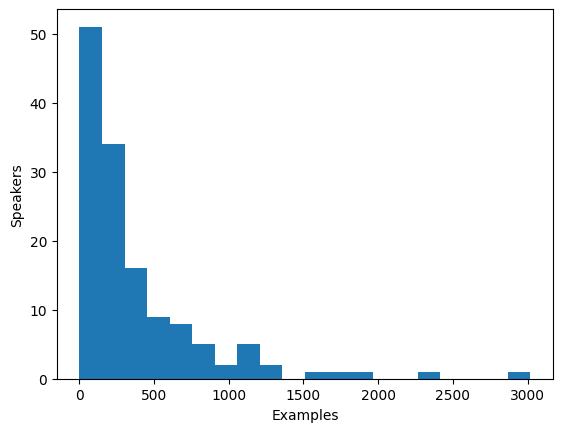

In [18]:
import matplotlib.pyplot as plt

plt.figure()
plt.hist(speaker_counts.values(), bins=20)
plt.ylabel("Speakers")
plt.xlabel("Examples")
plt.show()

In [19]:
def select_speaker(speaker_id):
    return 100 <= speaker_counts[speaker_id] <= 400


dataset = dataset.filter(select_speaker, input_columns=["speaker_id"])

In [20]:
len(set(dataset["speaker_id"]))

60

In [21]:
len(dataset)

13154

In [22]:
import os
import torch
import speechbrain
from speechbrain.pretrained import EncoderClassifier

spk_model_name = "speechbrain/spkrec-xvect-voxceleb"

device = "cuda" if torch.cuda.is_available() else "cpu"
speaker_model = EncoderClassifier.from_hparams(
    source=spk_model_name,
    run_opts={"device": device},
    savedir=os.path.join("/tmp", spk_model_name),
)


def create_speaker_embedding(waveform):
    with torch.no_grad():
        speaker_embeddings = speaker_model.encode_batch(torch.tensor(waveform))
        speaker_embeddings = torch.nn.functional.normalize(speaker_embeddings, dim=2)
        speaker_embeddings = speaker_embeddings.squeeze().cpu().numpy()
    return speaker_embeddings

In [23]:
def prepare_dataset(example):
    audio = example["audio"]

    example = processor(
        text=example["normalized_text"],
        audio_target=audio["array"],
        sampling_rate=audio["sampling_rate"],
        return_attention_mask=False,
    )

    # strip off the batch dimension
    example["labels"] = example["labels"][0]

    # use SpeechBrain to obtain x-vector
    example["speaker_embeddings"] = create_speaker_embedding(audio["array"])

    return example

In [24]:
! pip3 install librosa soundfile

In [25]:
processed_example = prepare_dataset(dataset[0])
list(processed_example.keys())

['input_ids', 'labels', 'speaker_embeddings']

In [26]:
processed_example["speaker_embeddings"].shape

(512,)

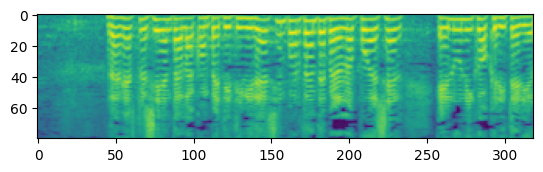

In [27]:
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(processed_example["labels"].T)
plt.show()

In [28]:
dataset = dataset.map(prepare_dataset, remove_columns=dataset.column_names)

In [29]:
def is_not_too_long(input_ids):
    input_length = len(input_ids)
    return input_length < 200


dataset = dataset.filter(is_not_too_long, input_columns=["input_ids"])
len(dataset)

8227

In [30]:
dataset = dataset.train_test_split(test_size=0.1)

In [31]:
from dataclasses import dataclass
from typing import Any, Dict, List, Union


@dataclass
class TTSDataCollatorWithPadding:
    processor: Any

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        input_ids = [{"input_ids": feature["input_ids"]} for feature in features]
        label_features = [{"input_values": feature["labels"]} for feature in features]
        speaker_features = [feature["speaker_embeddings"] for feature in features]

        # collate the inputs and targets into a batch
        batch = processor.pad(input_ids=input_ids, labels=label_features, return_tensors="pt")

        # replace padding with -100 to ignore loss correctly
        batch["labels"] = batch["labels"].masked_fill(batch.decoder_attention_mask.unsqueeze(-1).ne(1), -100)

        # not used during fine-tuning
        del batch["decoder_attention_mask"]

        # round down target lengths to multiple of reduction factor
        if model.config.reduction_factor > 1:
            target_lengths = torch.tensor([len(feature["input_values"]) for feature in label_features])
            target_lengths = target_lengths.new(
                [length - length % model.config.reduction_factor for length in target_lengths]
            )
            max_length = max(target_lengths)
            batch["labels"] = batch["labels"][:, :max_length]

        # also add in the speaker embeddings
        batch["speaker_embeddings"] = torch.tensor(speaker_features)

        return batch

In [32]:
data_collator = TTSDataCollatorWithPadding(processor=processor)

## Train the Model

In [31]:
from transformers import SpeechT5ForTextToSpeech

model = SpeechT5ForTextToSpeech.from_pretrained(checkpoint)

config.json:   0%|          | 0.00/2.06k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/585M [00:00<?, ?B/s]

In [32]:
model.config.use_cache = False

In [33]:
from transformers import Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    output_dir="speecht5_finetuned_voxpopuli_nl",  # change to a repo name of your choice
    per_device_train_batch_size=4,
    gradient_accumulation_steps=8,
    learning_rate=1e-5,
    warmup_steps=500,
    max_steps=4000,
    gradient_checkpointing=True,
    fp16=True,
    evaluation_strategy="steps",
    per_device_eval_batch_size=2,
    save_steps=1000,
    eval_steps=1000,
    logging_steps=25,
    report_to=["tensorboard"],
    load_best_model_at_end=True,
    greater_is_better=False,
    label_names=["labels"],
    push_to_hub=True,
)

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/transformers/training_args.py:1449: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [34]:
from transformers import Seq2SeqTrainer

trainer = Seq2SeqTrainer(
    args=training_args,
    model=model,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    data_collator=data_collator,
    tokenizer=processor,
)

max_steps is given, it will override any value given in num_train_epochs


In [35]:
trainer.train()

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss
1000,0.506000,0.464025
2000,0.485400,0.450527
3000,0.480000,0.447352
4000,0.481400,0.445818


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1876}
Your generation config was originally created from the model config, but the model config has changed since then. Unless you pass the `generation_config` argument to this model's `generate` calls, they will revert to the legacy behavior where the base `generate` parameterization is loaded from the model config instead. To avoid this behavior and this warning, we recommend you to overwrite the generation config model attribute before calling the model's `save_pretrained`, preferably also removing any generation kwargs from the model config. This warning will be raised to an exception in v4.41.
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/si

TrainOutput(global_step=4000, training_loss=0.5087841465473175, metrics={'train_runtime': 8599.3211, 'train_samples_per_second': 14.885, 'train_steps_per_second': 0.465, 'total_flos': 1.8395787548977344e+16, 'train_loss': 0.5087841465473175, 'epoch': 17.28795245813074})

## Load The Model

In [46]:
from transformers import SpeechT5ForTextToSpeech


model_dir = "speecht5_finetuned_voxpopuli_nl"


model = SpeechT5ForTextToSpeech.from_pretrained("finetuneSpeechT5-Spain/speecht5_finetuned_voxpopuli_nl").to("cuda:0")


## Inference

In [119]:
example = dataset["test"][304]
speaker_embeddings = torch.tensor(example["speaker_embeddings"]).unsqueeze(0)

In [120]:
text = "aprendizaje profundo para medios de comunicación" #Deeplearning for Media in Spanish

In [121]:
inputs = processor(text=text, return_tensors="pt")

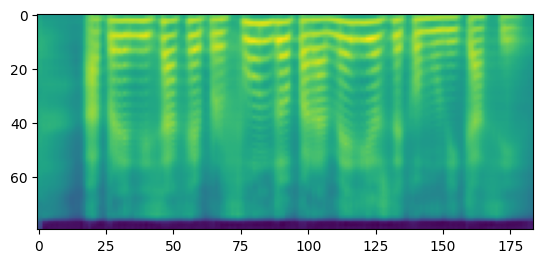

In [126]:
spectrogram = model.generate_speech(inputs["input_ids"].to("cuda:0"), speaker_embeddings.to("cuda:0"))
spectrogram_cpu = spectrogram.to("cpu")
plt.figure()
plt.imshow(spectrogram_cpu.T)
plt.show()

In [ ]:
from transformers import (
    SpeechT5ForTextToSpeech,
    SpeechT5HifiGan,
    SpeechT5FeatureExtractor,
    SpeechT5Processor,
)
vocoder = SpeechT5HifiGan.from_pretrained(
        "microsoft/speecht5_hifigan", device_map="cuda", torch_dtype=torch.float
    )


In [123]:
with torch.no_grad():
    
    speech = vocoder(spectrogram)

from IPython.display import Audio

Audio(speech.to("cpu").numpy(), rate=16000)

In [124]:
from scipy.io.wavfile import write
speech_1 = speech.to("cpu").numpy()
fs = 16000
speech_normalized = np.int16(speech_1 / np.max(np.abs(speech_1)) * 32767)

# 写入WAV文件
write('output.wav', fs, speech_normalized)